In [1]:
!apt-get update
!apt-get install -y build-essential
!pip install pybind11
!python setup.py build_ext --inplace

Leyendo lista de paquetes... Hecho
E: No se pudo abrir el fichero de bloqueo «/var/lib/apt/lists/lock» - open (13: Permiso denegado)
E: No se pudo bloquear el directorio /var/lib/apt/lists/
W: Se produjo un problema al desligar el fichero /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permiso denegado)
W: Se produjo un problema al desligar el fichero /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permiso denegado)
E: No se pudo abrir el fichero de bloqueo «/var/lib/dpkg/lock-frontend» - open (13: Permiso denegado)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
running build_ext
building 'ReplayMemory' extension
creating build/temp.linux-x86_64-cpython-311
g++ -pthread -B /home/qwerty/anaconda3/envs/master/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/qwerty/anaconda3/envs/master/include -fPIC -O2 -isystem /home/qwerty/anaconda3/envs/master/include -fPIC -I/home/qwerty/anaconda3/envs/master/lib/python3.11/site-packages

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
import random
import copy
from tqdm import tqdm
import Rocket as rck
import math
#import ReplayMemory as rpm


device="cuda" if torch.cuda.is_available() else "gpu"


In [2]:
class Red(nn.Module):

    def __init__(self,il=4,hl=10,ol=2):

        super().__init__()

        self.network=nn.Sequential(nn.Linear(il,hl),
                                  nn.ReLU(),
                                  nn.Linear(hl,hl),
                                  nn.ReLU(),
                                  nn.Linear(hl,ol))
    def forward(self,x):
        return self.network(x)


In [3]:


class ReplayMemory():

    def __init__(self,D=10000):
        self.deque=deque(maxlen=D)
        self.deque_shuffle=deque(maxlen=D)

    def append(self,x):
        self.deque.append(x)

    def minibatch(self,size=32):

        if(len(self.deque_shuffle)==0):
            self.deque_shuffle=copy.deepcopy(self.deque)
            random.shuffle(self.deque_shuffle)


        while(len(self.deque_shuffle)>0):
            ls=[]


            cont=0

            while cont<size and len(self.deque_shuffle)>0:
                ls.append(self.deque_shuffle[0])
                self.deque_shuffle.popleft()
                cont+=1


            yield np.array(ls)

    def reset(self,D=10000):
        self.deque=deque(maxlen=D)
        self.deque_shuffle=deque(maxlen=D)



In [4]:
class WrapAgent():

    def __init__(self,epsilon=0.7,decay=10):
        self.epsilon=epsilon
        self.decay=decay

        self.rng=np.random.default_rng(234343)


    def choose_action(self,env,state,repetition,Qnet,epsilon_o,step_epsilon,cont_epsilon):

        rand=self.rng.uniform(0,1)
        if(rand<(epsilon-step_epsilon*cont_epsilon) or rand<0.01):
            return env.sample()
        else:
            with torch.inference_mode():

                return torch.argmax(Qnet(torch.from_numpy(state).to(device).unsqueeze(dim=0).type(torch.float32))).detach().to("cpu").numpy()

In [5]:
gamma=0.9999
epsilon=1
decay=100
step_epsilon=0.001
cont_epsilon=0
tau=0.05
batch_size=128

start_train=100

max_steps=6000
total_repetitions=100
episodes=7000

state_length=9

rp_len=10000

rp=ReplayMemory(rp_len)

agent=WrapAgent(epsilon,decay)


Qnet=Red(state_length,30,4).to(device)
target=Red(state_length,30,4).to(device)

target.load_state_dict(Qnet.state_dict())

optimizer=torch.optim.SGD(Qnet.parameters(),lr=3e-4)
loss=nn.MSELoss()
rng=np.random.default_rng(33234)
env=rck.Rocket()

In [ ]:
rew=[]
t_steps=[]
error_t=[]



for i in range(episodes):

    #replay memory (s,r,a,s')



    with torch.inference_mode():
        reward=0
        time_steps=0

        #empiezo un episodio
        state=env.reset()

        for j in range(max_steps):

            action=agent.choose_action(env,state,i,Qnet,epsilon,step_epsilon,cont_epsilon)

            new=env.step(action)


            state_n=new[0:state_length]
            r=new[state_length]
            done=new[-1]

            reward+=r
            time_steps+=1


            if(done==0):
                rp.append(
                    np.hstack((state,r,np.array(action),state_n,done))
                )


                break
            else:

                rp.append(
                    np.hstack((state,r,np.array(action),state_n,done))
                )

                state=state_n



    rew.append(reward)
    t_steps.append(time_steps)

    error=0


    if(i>=start_train):

        for batch in rp.minibatch(batch_size):

            Qnet.train()

            #Estimo el q-value del estado con la red
            state=torch.from_numpy(batch[:,:state_length]).type(torch.float32).to(device)




            finish_states=torch.from_numpy(batch[:,-1]).type(torch.float32).unsqueeze(dim=0).to(device)
            sample_space=np.arange(4)


            actions=torch.vstack(
                tuple(
                    torch.from_numpy(sample_space==action_selected) for action_selected in batch[:,state_length+1]
                )
            ).to(device)



            q_values_qnet=Qnet(state)[actions].unsqueeze(dim=0)




            #Estimo el q_value del estado usando la ecuación de Bellman y la target net
            state_n=torch.from_numpy(batch[:,state_length+2:-1]).type(torch.float32).to(device)
            reward=torch.from_numpy(batch[:,state_length+1]).unsqueeze(dim=0).type(torch.float32).to(device)





            q_values_target=reward+gamma*torch.max(target(state_n),dim=1)[0]*finish_states




            err_train=loss(q_values_target,q_values_qnet)

            error+=(err_train.detach().to("cpu").numpy())


            optimizer.zero_grad()
            err_train.backward()

            optimizer.step()

            Qnet.eval()


        error_t.append(error)

        print(f"Process, {i*100/episodes:03.2f} %,  Episode {i:04d}, Steps {t_steps[-1]:03.0f}, Reward {rew[-1]:03.0f}, Error {error_t[-1]:09.5f}, Epsilon {epsilon-step_epsilon*cont_epsilon if epsilon-step_epsilon*cont_epsilon>0.01 else 0.01:03.3f}")

        if(i%1==0):
            #target.load_state_dict(Qnet.state_dict())

            Qnet_dict=Qnet.state_dict()
            target_dict=target.state_dict()

            for entrada in target_dict.keys():
                target_dict[entrada]=tau*Qnet_dict[entrada]+(1-tau)*target_dict[entrada]

            target.load_state_dict(target_dict)
            torch.save(Qnet.state_dict(),f="net.pth")

        cont_epsilon+=1

Process, 1.43 %,  Episode 0100, Steps 030, Reward -430, Error 071.87423, Epsilon 1.000
Process, 1.44 %,  Episode 0101, Steps 020, Reward -606, Error 068.71767, Epsilon 0.999
Process, 1.46 %,  Episode 0102, Steps 018, Reward -230, Error 065.42293, Epsilon 0.998
Process, 1.47 %,  Episode 0103, Steps 016, Reward -472, Error 065.41921, Epsilon 0.997
Process, 1.49 %,  Episode 0104, Steps 030, Reward -432, Error 062.64553, Epsilon 0.996
Process, 1.50 %,  Episode 0105, Steps 019, Reward -127, Error 060.11430, Epsilon 0.995
Process, 1.51 %,  Episode 0106, Steps 021, Reward -283, Error 057.93233, Epsilon 0.994
Process, 1.53 %,  Episode 0107, Steps 011, Reward -436, Error 055.28633, Epsilon 0.993
Process, 1.54 %,  Episode 0108, Steps 014, Reward -367, Error 053.03141, Epsilon 0.992
Process, 1.56 %,  Episode 0109, Steps 019, Reward -247, Error 050.78391, Epsilon 0.991
Process, 1.57 %,  Episode 0110, Steps 013, Reward -312, Error 050.75012, Epsilon 0.990
Process, 1.59 %,  Episode 0111, Steps 013, 

KeyboardInterrupt: 

In [ ]:
torch.save(Qnet.state_dict(),f="net.pth")

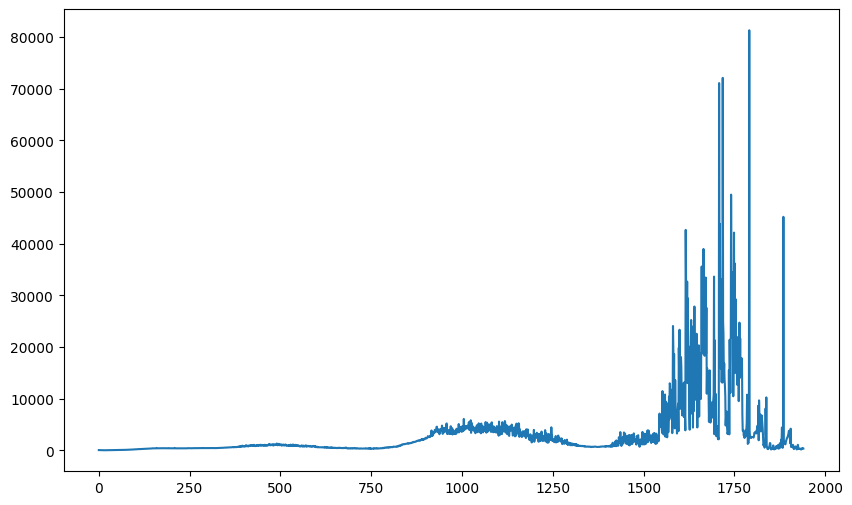

In [ ]:
plt.figure(1,figsize=(10,6))

plt.plot(np.arange(len(error_t)),error_t)

(array([1.431e+03, 2.850e+02, 7.600e+01, 3.300e+01, 2.900e+01, 1.200e+01,
        1.100e+01, 1.000e+01, 9.000e+00, 3.000e+00, 6.000e+00, 7.000e+00,
        3.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

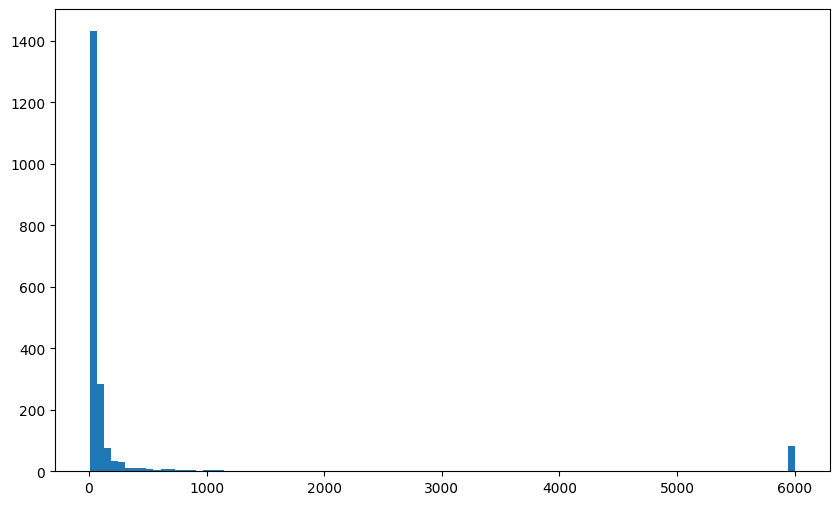

In [ ]:
plt.figure(1,figsize=(10,6))

plt.hist(t_steps,bins=100)

In [75]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.rcParams['animation.embed_limit'] = 2**128
plt.ioff()

fig, ax = plt.subplots(figsize=(5,5))

state=env.reset()
flag=True

def animate(t):

    global state
    global flag

    ax.clear()
    xlim=10
    ylim=10
    plt.tight_layout()

    

    action=torch.argmax(Qnet(torch.from_numpy(state[:state_length]).unsqueeze(dim=0).type(torch.float32).to(device))).detach().to("cpu").squeeze().item()

    
    new=env.step(action)

    state=new[0:state_length]
    r=new[4]
    done=new[5]
    
    
    x_cm=state[0]
    y_cm=state[1]
    
    phi=state[2]


    if(action==1 and flag==False):
        flag=True
    elif(action==1 and flag==True):
        flag=False
    
    
    ax.set_ylim(-ylim,ylim)
    
    ax.set_xlim(-xlim,xlim)


    x1=(-0.25)*np.sin(phi)+(-2)*np.cos(phi)
    x2=(0.25)*np.sin(phi)+(-2)*np.cos(phi)
    x3=(-2-0.5)*np.cos(phi)
    x4=(-0.25)*np.sin(phi)+(-2)*np.cos(phi)

    y1=-(-0.25)*np.cos(phi)+(-2)*np.sin(phi)
    y2=-(+0.25)*np.cos(phi)+(-2)*np.sin(phi)
    y3=-(-2-0.5)*np.sin(phi)
    y4=-(-0.25)*np.cos(phi)+(-2)*np.sin(phi)
    
    
    
    
    rect = Rectangle((x_cm-0.25, y_cm-2), width=0.5, height=4,angle=phi*180/np.pi,rotation_point="center", edgecolor='blue', facecolor='lightblue')
    
    ax.add_patch(rect)

    if(flag):
        plt.plot(np.array([-y1+x_cm,-y2+x_cm,x_cm+2.5*np.sin(phi),-y4+x_cm]),np.array([x1+y_cm,x2+y_cm,y_cm-2.5*np.cos(phi),x4+y_cm]),color="red",linewidth=1.0)
        #plt.plot([(x_cm)*np.sin(phi)+(y_cm-2)*np.cos(phi)],[(x_cm)*np.cos(phi)+(y_cm-2)*np.sin(phi)],color="red",linewidth=1.0)


FuncAnimation(fig, animate, frames=100,interval=40)